In [2]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation,LinearTriInterpolator
import rasterio
import pandas as pd

In [7]:
points=gpd.read_file('../shp/combi.shp')
print(points.head())
print(points.set_crs("epsg:32718"))

   id                                           geometry
0   1  POLYGON ((-10423170.940 5164494.710, -10425171...
   id                                           geometry
0   1  POLYGON ((-10423170.940 5164494.710, -10425171...


In [3]:
points=pd.read_csv('../geodataf/geodata.csv')

In [5]:
geoDF=points[['X','Y','Z']]

In [6]:
from shapely.geometry import Point

geometry=[Point(xy)for xy in zip(pd.to_numeric(geoDF['X']),pd.to_numeric(geoDF['Y']))]
geoDF=gpd.GeoDataFrame(geoDF,crs='epsg:4326',geometry=geometry)
geoDF
          

,X,Y,Z,geometry
0,-10423327.04,5165424.45,272.51,POINT (-10423327.040 5165424.450)
1,-10423331.98,5165424.45,272.44,POINT (-10423331.980 5165424.450)
2,-10423338.73,5165424.50,272.36,POINT (-10423338.730 5165424.500)
3,-10423336.27,5165424.97,272.39,POINT (-10423336.270 5165424.970)
4,-10423328.95,5165426.42,272.48,POINT (-10423328.950 5165426.420)
...,...,...,...,...
1436153,-10424341.58,5164498.82,285.15,POINT (-10424341.580 5164498.820)
1436154,-10424313.93,5164494.79,283.54,POINT (-10424313.930 5164494.790)
1436155,-10424368.48,5164499.68,285.53,POINT (-10424368.480 5164499.680)
1436156,-10424375.46,5164499.07,285.40,POINT (-10424375.460 5164499.070)


In [8]:
geoDF=geoDF[['Z','geometry']]
geoDF.reset_index()

,index,Z,geometry
0,0,272.51,POINT (-10423327.040 5165424.450)
1,1,272.44,POINT (-10423331.980 5165424.450)
2,2,272.36,POINT (-10423338.730 5165424.500)
3,3,272.39,POINT (-10423336.270 5165424.970)
4,4,272.48,POINT (-10423328.950 5165426.420)
...,...,...,...
1436153,1436153,285.15,POINT (-10424341.580 5164498.820)
1436154,1436154,283.54,POINT (-10424313.930 5164494.790)
1436155,1436155,285.53,POINT (-10424368.480 5164499.680)
1436156,1436156,285.40,POINT (-10424375.460 5164499.070)


In [9]:
totalPointsArray=np.zeros([geoDF.shape[0],3])
for index ,point in geoDF.iterrows():
    pointArray=np.array([point.geometry.coords.xy[0][0],point.geometry.coords.xy[1][0],point['Z']])
    totalPointsArray[index]=pointArray
    
totalPointsArray

array([[-1.04233270e+07,  5.16542445e+06,  2.72510000e+02],
       [-1.04233320e+07,  5.16542445e+06,  2.72440000e+02],
       [-1.04233387e+07,  5.16542450e+06,  2.72360000e+02],
       ...,
       [-1.04243685e+07,  5.16449968e+06,  2.85530000e+02],
       [-1.04243755e+07,  5.16449907e+06,  2.85400000e+02],
       [-1.04243808e+07,  5.16449899e+06,  2.85140000e+02]])

In [10]:
triFn=Triangulation(totalPointsArray[:,0],totalPointsArray[:,1])

linTriFin=LinearTriInterpolator(triFn,totalPointsArray[:,2])

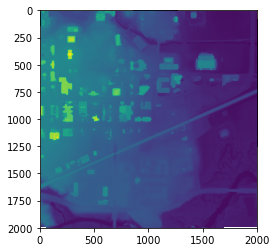

In [27]:
rasterRes=1

xCoords =np.arange(totalPointsArray[:,0].min(),totalPointsArray[:,0].max()+rasterRes,rasterRes)
yCoords=np.arange(totalPointsArray[:,1].min(),totalPointsArray[:,1].max()+rasterRes,rasterRes)
zCoords=np.zeros([yCoords.shape[0],xCoords.shape[0]])

for indexX, x in np.ndenumerate(xCoords):
    for indexY, y in np.ndenumerate(yCoords):
        tempZ=linTriFin(x,y)
        
        if tempZ==tempZ:
            zCoords[indexY,indexX]=tempZ
        else:
            zCoords[indexY,indexX]=np.nan
            
plt.imshow(zCoords)

In [26]:
yCoords

array([], dtype=float64)

In [28]:
from rasterio.transform import Affine

transform=Affine.translation(xCoords[0] -rasterRes/2,yCoords[0] - rasterRes/2) *Affine.scale(rasterRes,rasterRes)
transform


Affine(1.0, 0.0, -10425172.44,
       0.0, 1.0, 5164494.21)

In [29]:
from rasterio.crs import CRS
rasterCrs=CRS.from_epsg(32718)
rasterCrs.data

{'init': 'epsg:32718'}

In [30]:
triInterpRaster = rasterio.open('../tif/triangleInterpolation.tif',
                                'w',
                                driver='GTiff',
                                height=zCoords.shape[0],
                                width=zCoords.shape[1],
                                count=1,
                                dtype=zCoords.dtype,
                                #crs='+proj=latlong',
                                crs={'init': 'epsg:32718'},
                                transform=transform,
                                )
triInterpRaster.write(zCoords,1)
triInterpRaster.close()

In [ ]:
#places to interporlate
from shapely.geometry import Polygon

MINX, MINY, MAXX, MAXY = [-93.756155, 41.918015, -93.747334, 41.921429]
polygon = Polygon(((MINX, MINY), (MINX, MAXY), (MAXX, MAXY), (MAXX, MINY), (MINX, MINY)))

grid = gpd.GeoDataFrame([polygon], columns=["geometry"])
grid.set_crs(epsg=4326, inplace=True)



In [35]:
geoDFR=geoDF.drop(labels='Z',axis=1)
geoDFR.reset_index()

,index,geometry
0,0,POINT (-10423327.040 5165424.450)
1,1,POINT (-10423331.980 5165424.450)
2,2,POINT (-10423338.730 5165424.500)
3,3,POINT (-10423336.270 5165424.970)
4,4,POINT (-10423328.950 5165426.420)
...,...,...
1436153,1436153,POINT (-10424341.580 5164498.820)
1436154,1436154,POINT (-10424313.930 5164494.790)
1436155,1436155,POINT (-10424368.480 5164499.680)
1436156,1436156,POINT (-10424375.460 5164499.070)


In [41]:
geoDFR[:100]

,geometry,elev
0,POINT (-10423327.040 5165424.450),272.51
1,POINT (-10423331.980 5165424.450),272.44
2,POINT (-10423338.730 5165424.500),272.36
3,POINT (-10423336.270 5165424.970),272.39
4,POINT (-10423328.950 5165426.420),272.48
...,...,...
95,POINT (-10423390.010 5165427.160),271.92
96,POINT (-10423380.280 5165429.070),271.86
97,POINT (-10423377.810 5165429.550),271.86
98,POINT (-10423375.430 5165430.030),271.87


In [53]:
interpolatedPoints = geoDFR[:500000]
interpolatedPoints['elev'] = ''
for index, point in interpolatedPoints.iterrows():
    tempZ = linTriFin(point.geometry.coords.xy[0][0],point.geometry.coords.xy[1][0])
    if tempZ == tempZ:
        interpolatedPoints.loc[index,'elev'] = float(tempZ)
    else:
        interpolatedPoints.loc[index,'elev'] = np.nan
#save as shapefile
interpolatedPoints.to_file('../shp/interpolatedPoints.shp')

/opt/miniconda/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/opt/miniconda/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


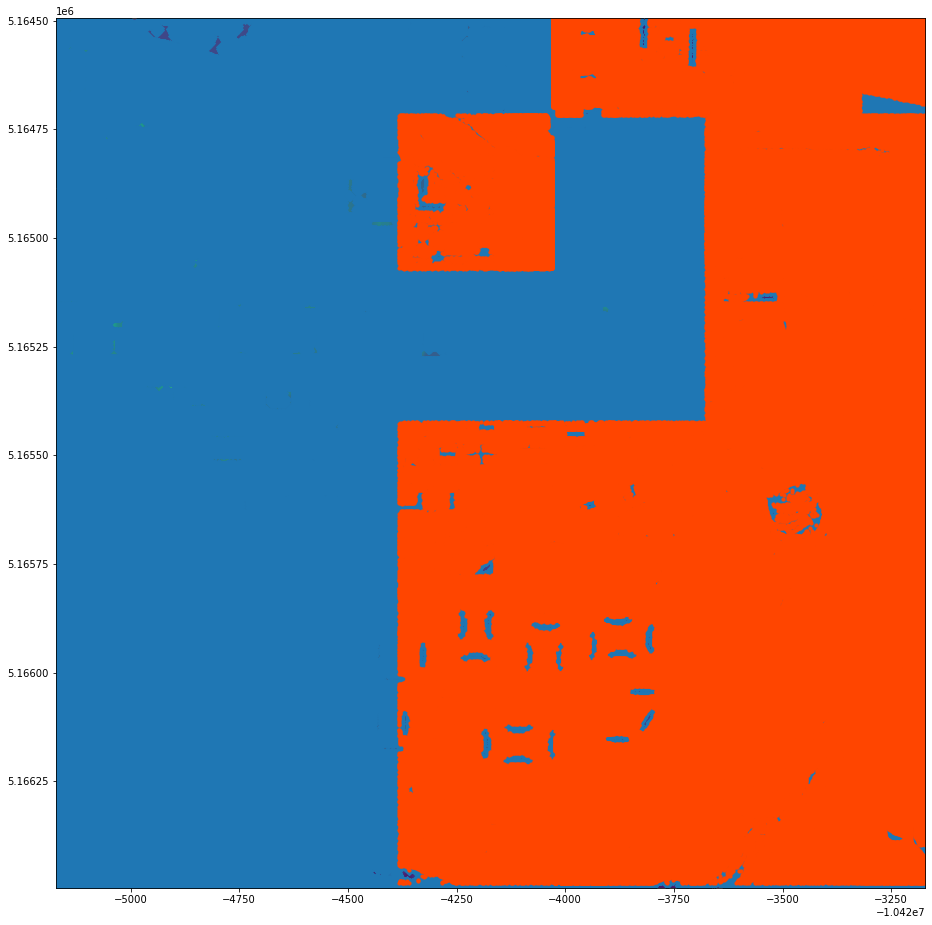

In [55]:
from rasterio.plot import show
src = rasterio.open("../tif/triangleInterpolation.tif")

fig, ax = plt.subplots(figsize=(24,16))

geoDF.plot(ax=ax, marker='D',markersize=50,aspect=1)
interpolatedPoints.plot(ax=ax, markersize=10, color='orangered',aspect=1)
show(src)
plt.show()